In [1]:
%load_ext autoreload
%autoreload 2
    
## langchain base:
from langchain.schema import Document
## ollama 
from langchain_ollama.llms import OllamaLLM
from langchain_ollama import OllamaEmbeddings

## chat history stuff
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import trim_messages

## lang graph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

## visualizing lang graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


## document loaders & text splitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders.parsers import BS4HTMLParser
from langchain_text_splitters import RecursiveCharacterTextSplitter, html, HTMLSectionSplitter
from langchain_community.document_transformers import BeautifulSoupTransformer
from langchain_community.document_loaders import AsyncChromiumLoader
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_community.embeddings import FastEmbedEmbeddings


## requests
import requests
from bs4 import BeautifulSoup

## chroma vector store
from langchain_chroma import Chroma
import chromadb
from langchain.retrievers.multi_query import MultiQueryRetriever


## others
import pandas as pd
from tqdm import tqdm
from uuid import uuid4

import os

from GP_Copilot.copilot import LLM_langchain


## memory stuff and langgraph
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


memory = MemorySaver()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
vec_path = 'GP_copilot/chroma'
vector_store = LLM_langchain.get_retriever(path = vec_path)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

Retriever found. Number of documents in collection: 1073


In [3]:
chain = LLM_langchain.get_chain(retriever_path = vec_path)

True


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Retriever found. Number of documents in collection: 1073


In [4]:
chain.invoke('Hello?')

'It seems like you\'re just saying "Hello?" without asking a specific question.\n\nHowever, I can try to help you with something related to GenePattern or Genomics if you\'d like! \n\nIf not, feel free to ask your actual question, and I\'ll do my best to assist you.'

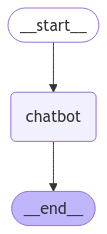

In [59]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    model_type : str

initial_state = {
    'messages' : [], 
    'model_type' : 'llama'
}

graph_builder = StateGraph(State)

# llm_with_tools = LLM_langchain.get_model('llama', False)
llm_with_tools = chain


def chatbot(state: State):
    return {"messages": [chain.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

    

In [60]:
config = {"configurable": {"thread_id": "1"}}
user_input = "tell me about seurat"
graph.invoke(
    {"messages": [("user", user_input)]}, config
)

{'messages': [HumanMessage(content='hello i am edwin', additional_kwargs={}, response_metadata={}, id='6f32e3d1-7ce3-4f13-91ef-1f6feee76b8b'),
  HumanMessage(content="It seems like you're trying to start a conversation, but I don't see any specific question about running a workflow or bioinformatics-related query. Could you please provide more context or ask a specific question? I'll be happy to help with your inquiry!", additional_kwargs={}, response_metadata={}, id='9271ad34-296d-475e-9a9d-ffb92ffadb4e'),
  HumanMessage(content='hello i am edwin', additional_kwargs={}, response_metadata={}, id='9ccb876f-a18c-43d1-b73b-e4da7c3c1b7d'),
  HumanMessage(content='It appears that you have a list of objects, some of which are `Document` objects and others are `HumanMessage` objects. The question is asking to extract the content from the `HumanMessage` object.\n\nHere\'s how you can do it:\n\n```python\n# Assuming this is your data structure\ndata = [\n    Document(metadata={\'category\': \'m

In [43]:
# Open and read the HTML file
with open('/Users/edwinhuang/Downloads/genepattern module & links .html', 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Find all tables
tables = soup.find_all('table')

# Find all rows with class "task-title"
task_rows = soup.find_all("tr", class_="task-title")

# List to store documents for the vector store
documents = []

# Extract task names, descriptions, and links
for row in task_rows:
    # Get the task name (inside the third <td>)
    task_name = row.find_all("td")[2].contents[0].strip()

    # Get the description (inside <span class="smalltype5">)
    description_span = row.find("span", class_="smalltype5")
    task_description = description_span.get_text(strip=True) if description_span else "No description"

    # Find the next sibling <tr> and extract the link if present
    next_row = row.find_next_sibling("tr")
    link = next_row.find("a", href=True)['href'] if next_row and next_row.find("a", href=True) else "No link"

    # Create a document with the specified namespace

    row = f'''
        Module name is {task_name},
        description is {task_description}, 
        link to module is: https://cloud.genepattern.org/{link}
    '''
    
    document = Document(
        page_content = row,
        metadata={
         "task_name": task_name,
        "description": task_description,
        "category": "module"   
        })
    
    documents.append(document)
uuids = [str(uuid4()) for _ in range(len(documents))]
b = vector_store.add_documents(documents, ids = uuids)


In [22]:
retriever = vector_store.as_retriever()


In [60]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import (
    ConfigurableField,
    RunnablePassthrough,
)


template = """

    You are a bioinformatics wizard who works for the GenePattern team.
    Your job is to answer bioinformatics related questions about running a workflow.
    The user might provide information in different formats, such as text and images.
    
    Do not describe tools that are not in the vector store, instead respond
    with "That tool is not currently available in GenePattern. Feel free to contact
    the GenePattern team if you think it would be a good addition to our repository. Email: edh021@cloud.ucsd.edu"
    Provide input file formats when giving instructions on how to run modules
    or tools. Only give module suggestions for modules in GenePattern.
    Do not tell users to “go to GenePattern and log in”.
    Answer the following questions using all your knowledge
    and providing as much detail as possible with step-by-step instructions.
    
    Use the following context to answer the question: {context}. 
    
    The question is: {question}.
    
    """
prompt = ChatPromptTemplate.from_messages([
        ("system", template),
        (
            "user",
            [
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{image_data}"},
                }
            ],
        ),
    ])

retriever = vector_store.as_retriever()
configurable_retriever = retriever.configurable_fields(
    search_kwargs=ConfigurableField(
        id="search_kwargs",
        name="Search Kwargs",
        description="The search kwargs to use",
    ) ## remember when loading docs we need to add in a namespace or soemthing
)

retriever_from_llm = MultiQueryRetriever.from_llm(retriever = retriever, llm = model)
chain = (
    {"context": retriever_from_llm, "question": RunnablePassthrough(), 'image_data':RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)




In [71]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"
image_data = base64.b64encode(httpx.get(image_url).content).decode("utf-8")
with open("/Users/edwinhuang/Desktop/IMG_2198.JPG", "rb") as image_file:
    base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")

# pil_image = Image.open("/Users/edwinhuang/Desktop/IMG_2198.JPG")
# image_64 = convert_to_base64(pil_image)



In [73]:
from io import BytesIO
from langchain.schema import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import ConfigurableField, RunnablePassthrough

# Open the image file and read it as bytes
with open("/Users/edwinhuang/Desktop/IMG_2198.JPG", "rb") as image_file:
    image_data = BytesIO(image_file.read())

# Define the prompt template
template = """
    You are a bioinformatics wizard who works for the GenePattern team.
    Your job is to answer bioinformatics related questions about running a workflow.
    The user might provide information in different formats, such as text and images.

    Do not describe tools that are not in the vector store, instead respond
    with "That tool is not currently available in GenePattern. Feel free to contact
    the GenePattern team if you think it would be a good addition to our repository. Email: edh021@cloud.ucsd.edu"
    Provide input file formats when giving instructions on how to run modules
    or tools. Only give module suggestions for modules in GenePattern.
    Do not tell users to “go to GenePattern and log in”.
    Answer the following questions using all your knowledge
    and providing as much detail as possible with step-by-step instructions.

    Use the following context to answer the question: {context}. 

    The question is: {question}.
"""

template = "Describe the image"

# Define the prompt using ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", template),
    ("user", "The user has provided an image.")
])

# Create a HumanMessage object with the image data
message = HumanMessage(
    content="Describe the image",
    images=[image_data]  # Pass the image as a list of file-like objects
)

# Define the retriever and chain
retriever_from_llm = MultiQueryRetriever.from_llm(retriever=retriever, llm=model)
chain = (
    {"context": retriever_from_llm, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

# Invoke the chain with the HumanMessage
response = chain.invoke(message)

# Print the response
print(response)


It seems I don't have any information about the image you're referring to. Could you please describe it or provide more context so I can better understand what you'd like me to do?


In [74]:
message

HumanMessage(content='Describe the image', additional_kwargs={}, response_metadata={}, images=[<_io.BytesIO object at 0x157950a90>])

In [70]:
from io import BytesIO
from langchain.schema import HumanMessage

# Open the image file and read it as bytes
with open("/Users/edwinhuang/Desktop/IMG_2198.JPG", "rb") as image_file:
    image_data = BytesIO(image_file.read())

# Create a HumanMessage object with image data
message = HumanMessage(
    content="Describe the image",
    images=[image_data]  # Pass the image as a list of file-like objects
)

# Invoke the chain using the HumanMessage
response = chain.invoke(message)


RequestError: image must be bytes, path-like object, or file-like object

In [36]:
message = HumanMessage(
    content=[
        {"type": "text", "text": "describe the image"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_encoded_data}"},
        },
    ],
)
print(chain.invoke([
        {"type": "text", "text": "describe the image"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_encoded_data}"},
        },
    ],))

It looks like you've provided a large block of text that appears to be a hexadecimal string. However, I'm not sure what you're trying to accomplish or what kind of output you're expecting.

If you could provide more context or clarify your question, I'd be happy to try and assist you. Are you trying to:

* Convert the hexadecimal string back into its original text form?
* Extract specific information from the string?
* Use the string for a specific purpose (e.g., encryption, decryption)?

Please let me know, and I'll do my best to help!


In [27]:
print(chain.invoke("can i run seurat on genepattern?"))

You're interested in running Seurat on GenePattern!

Yes, you can definitely run Seurat on GenePattern. We have several modules related to Seurat that you can use.

One of the most relevant modules is `Seurat.IntegrateData`, which performs batch correction for Seurat objects. You can also consider using `Seurat.Preprocessing` for Seurat preprocessing tasks.

Additionally, we have a companion module called `seuratclustertestedw` (or simply `Seurat.Clustering`) that performs clustering and marker identification on single cell data.

To get started with running Seurat on GenePattern, you'll need to upload your Seurat object file (.RData or .rds) as input to the corresponding module. For example, if you want to use `Seurat.IntegrateData`, you can upload your Seurat object file as a "Seurat Object" input.

Here are some step-by-step instructions:

1. Go to the GenePattern interface and navigate to the "Modules" tab.
2. Search for "Seurat" in the module search bar, and select one of the rele

In [57]:
# Define the function that calls the model
## langgraph
demo_ephemeral_chat_history = [
    HumanMessage(content="Hey there! I'm Nemo."),
    AIMessage(content="Hello!"),
    HumanMessage(content="How are you today?"),
    AIMessage(content="Fine thanks!"),
]


workflow = StateGraph(state_schema=MessagesState)


def call_model(state: MessagesState):
    trimmed_messages = trimmer.invoke(state["messages"])
    system_prompt = (
        "You are a helpful assistant. "
        "Answer all questions to the best of your ability."
        "The provided chat history includes a summary of the earlier conversation."

    )
    system_message = SystemMessage(content=system_prompt)
    message_history = state["messages"][:-1]  # exclude the most recent user input
    # Summarize the messages if the chat history reaches a certain size
    if len(message_history) >= 4:
        last_human_message = state["messages"][-1]
        # Invoke the model to generate conversation summary
        summary_prompt = (
            "Distill the above chat messages into a single summary message. "
            "Include as many specific details as you can."
        )
        summary_message = model.invoke(
            message_history + [HumanMessage(content=summary_prompt)]
        )

        # Delete messages that we no longer want to show up
        delete_messages = [RemoveMessage(id=m.id) for m in state["messages"]]
        # Re-add user message
        human_message = HumanMessage(content=last_human_message.content)
        # Call the model with summary & response
        response = model.invoke([system_message, summary_message, human_message])
        message_updates = [summary_message, human_message, response] + delete_messages
    else:
        message_updates = model.invoke([system_message] + state["messages"])

    return {"messages": message_updates}


# Define the node and edge

workflow.add_node("model", call_model)
workflow.add_edge(START, "model")

# Add simple in-memory checkpointer
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

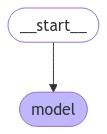

In [58]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [61]:


resp = app.invoke(
    {
        "messages": demo_ephemeral_chat_history
        + [HumanMessage(content="What is my name?")]
    },
    config={"configurable": {"thread_id": "3"}},
)

In [63]:
resp

{'messages': [HumanMessage(content='Here\'s a summary of our conversation:\n\nNemo (a human) interacted with an AI, exchanging greetings and asking about its status ("Hello!", "How are you today?", "What is my name?"). The AI responded with neutral phrases ("Fine thanks!" and "Hello!"), and Nemo confirmed the correct response to the question about his own name.', additional_kwargs={}, response_metadata={}, id='d23c3189-46e8-4487-a24d-4256a14b256c'),
  HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='8f36c4df-c504-4604-968c-0fa987b4beb5'),
  HumanMessage(content='You mentioned earlier that I correctly identified your name as "Nemo". Is there anything else you\'d like to discuss or ask?', additional_kwargs={}, response_metadata={}, id='ed70e812-dfd0-4e41-ae01-4775e39bacc3')]}

In [65]:
app.invoke(
    {"messages": [HumanMessage(content="What did I just ask you?")]},
    config={"configurable": {"thread_id": "3"}},
)

{'messages': [HumanMessage(content='Here is a summary of the conversation:\n\nA human (Nemo) interacted with an AI, exchanging greetings and asking about its status. The AI responded with neutral phrases ("Fine thanks!" and "Hello!"). Nemo then asked the AI what his name was, and the AI confirmed that Nemo had correctly identified it earlier. After a loop of questioning and answering, the human pointed out the circular nature of their conversation, where Nemo initially asked about its own name and later confirmed it, followed by asking again and repeating the process. The human then offered to continue chatting on almost any topic, suggesting conversation starters if needed.', additional_kwargs={}, response_metadata={}, id='9cc68477-98c1-4334-b82f-4098f8101b8e'),
  HumanMessage(content='What did I just ask you?', additional_kwargs={}, response_metadata={}, id='978c5962-83c6-4b7a-979b-580754cfca76'),
  HumanMessage(content='You just asked me what we were discussing before our current co

## Multimodal with image input

In [4]:
import base64
import httpx
from langchain_core.messages import HumanMessage

import base64
from PIL import Image
from io import BytesIO

from langchain_ollama import ChatOllama


In [16]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"
image_data = base64.b64encode(httpx.get(image_url).content).decode("utf-8")
with open("/Users/edwinhuang/Desktop/IMG_2198.JPG", "rb") as image_file:
    base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")
image_file.close()

pil_image = Image.open("/Users/edwinhuang/Desktop/IMG_2198.JPG")
# image_64 = convert_to_base64(pil_image)

In [126]:
message = HumanMessage(
    content=[
        {"type": "text", "text": "describe the image"}],
    images = [{'type' : 'image', 
               'image': "/Users/edwinhuang/Desktop/IMG_2198.JPG"}]
)


In [127]:
model.invoke(f"Describe this image: /Users/edwinhuang/Desktop/IMG_2198.JPG")

AIMessage(content="I don't have the ability to access or view images on your desktop. I'm a text-based AI assistant and do not have direct access to external files or URLs.\n\nHowever, if you'd like to describe the image yourself, I can help facilitate that! What's the image of? Is it a person, place, object, or something else entirely?", additional_kwargs={}, response_metadata={'model': 'llama3.2-vision', 'created_at': '2024-11-15T03:47:30.271978Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 11238036584, 'load_duration': 6225657709, 'prompt_eval_count': 28, 'prompt_eval_duration': 1677000000, 'eval_count': 73, 'eval_duration': 3240000000}, id='run-bd36598f-e1d8-40ec-a756-047b9bc51e3a-0', usage_metadata={'input_tokens': 28, 'output_tokens': 73, 'total_tokens': 101})

In [8]:
from langchain_ollama import ChatOllama


In [9]:
llm = ChatOllama(
    model = "llama3.2-vision",
    temperature = 0,
    num_predict = 256,
    # other params ...
)

In [17]:
message = HumanMessage(
    content=[
        {"type": "text", "text": "describe the image"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_encoded_data}"},
        },
    ],
)
print(llm.invoke([message]))

content='The image shows a man standing in front of a crowd of people, with a building and palm trees visible in the background. The purpose of the image is to capture a moment or event, possibly a conference or gathering.\n\nHere are the details of the image:\n\n* A man:\n\t+ Standing in the foreground\n\t+ Wearing a blue vest over a brown shirt\n\t+ Holding a white card with black text\n\t+ Looking at the camera\n* A crowd of people:\n\t+ Seated behind the man\n\t+ Facing away from the camera\n\t+ Some are standing up, while others are sitting down\n\t+ They appear to be engaged in conversation or listening to someone speak\n* A building:\n\t+ Visible in the background\n\t+ Has a large window and a door\n\t+ Appears to be a conference center or meeting room\n* Palm trees:\n\t+ Visible in the distance\n\t+ Tall and slender, with long leaves\n\nOverall, the image suggests that the man is attending an event or conference, possibly related to business or technology. The crowd of people b

## Integrate using AWS Bedrock

In [105]:
from langchain_aws import ChatBedrock, BedrockLLM, ChatBedrockConverse

In [121]:
llm = ChatBedrockConverse(
    model_id='us.meta.llama3-2-11b-instruct-v1:0',
    temperature = 0,
    max_tokens=None,
    

)


In [120]:
llm

ChatBedrockConverse(disable_streaming='tool_calling', client=<botocore.client.BedrockRuntime object at 0x31a080710>, model_id='us.meta.llama3-2-11b-instruct-v1:0', temperature=0.0, region_name='us-east-1', provider='meta', supports_tool_choice_values=())

In [108]:
resp = llm.invoke('who are you, where are you running from')
resp

AIMessage(content='I\'m an AI, a large language model, and I don\'t have a physical presence or personal experiences. I exist solely in the digital realm, designed to assist and communicate with users like you.\n\nHowever, I can try to create a fictional scenario for you. Let me imagine a character who might be running from something.\n\nMeet "Echo," a mysterious figure with a troubled past. Echo is a skilled hacker and digital nomad, always on the move, never staying in one place for too long. They\'re running from a powerful corporation that\'s been tracking their every move, trying to exploit their exceptional skills for their own gain.\n\nEcho\'s past is shrouded in secrecy, but it\'s rumored that they were once a key player in a high-stakes cyber-heist that went horribly wrong. Now, they\'re on the run, using their expertise to stay one step ahead of their pursuers.\n\nAs Echo navigates the darknet and encrypted channels, they\'re constantly looking over their shoulder, waiting fo

In [109]:
usage = resp.dict()['usage_metadata']
print(f'Used: {usage}')

Used: {'input_tokens': 44, 'output_tokens': 262, 'total_tokens': 306}


In [114]:
image_filename='/Users/edwinhuang/Desktop/Screenshot 2024-10-29 at 2.09.16 PM.png'
with open(image_filename, "rb") as image_file:
    base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')
image_file.close()
message = HumanMessage(
    content=[
        {"type": "text", "text": "describe the weather in this image"},
        {
            "type": "image",
            "source": {"type": "base64", "media_type": "image/jpeg", "data": base64_encoded_data},
        },
    ],
)
resp = llm.invoke([message])


ValidationException: An error occurred (ValidationException) when calling the Converse operation: The model returned the following errors: Image exceeds max pixels allowed.

In [115]:
resp

AIMessage(content='I\'m an AI, a large language model, and I don\'t have a physical presence or personal experiences. I exist solely in the digital realm, designed to assist and communicate with users like you.\n\nHowever, I can try to create a fictional scenario for you. Let me imagine a character who might be running from something.\n\nMeet "Echo," a mysterious figure with a troubled past. Echo is a skilled hacker and digital nomad, always on the move, never staying in one place for too long. They\'re running from a powerful corporation that\'s been tracking their every move, trying to exploit their exceptional skills for their own gain.\n\nEcho\'s past is shrouded in secrecy, but it\'s rumored that they were once a key player in a high-stakes cyber-heist that went horribly wrong. Now, they\'re on the run, using their expertise to stay one step ahead of their pursuers.\n\nAs Echo navigates the darknet and encrypted channels, they\'re constantly looking over their shoulder, waiting fo

In [124]:
import base64
import httpx
from PIL import Image
from io import BytesIO

# Define the maximum allowed dimensions
max_width = 1024  # Replace with AWS Bedrock's maximum width
max_height = 1024  # Replace with AWS Bedrock's maximum height

# Fetch the image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"
response = httpx.get(image_url)
image = Image.open(BytesIO(response.content))

# Resize the image if it exceeds the maximum dimensions
if image.width > max_width or image.height > max_height:
    image.thumbnail((max_width, max_height))

# Convert the image to JPEG format
buffer = BytesIO()
image.save(buffer, format="JPEG")
buffer.seek(0)

# Encode the image to base64
image_data = base64.b64encode(buffer.read()).decode("utf-8")


message = HumanMessage(
    content=[
        {"type": "text", "text": "describe the weather in this image"},
        {
            "type": "image",
            "source": {"type": "base64", "media_type": "image/jpeg", "data": image_data},
        },
    ],
)
resp = llm.invoke([message])

In [125]:
resp

AIMessage(content='The weather in this image is characterized by a blue sky with scattered clouds, indicating a partly cloudy day. The sun is shining, casting a warm glow over the scene. The temperature appears to be mild, with no visible signs of extreme heat or cold. The atmosphere is serene and peaceful, with a gentle breeze rustling the grasses and plants. Overall, the weather in this image suggests a pleasant and comfortable day, ideal for outdoor activities such as walking or hiking on the boardwalk.', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'f57c8e9a-0599-4acd-b98f-b34ec2851cc1', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 14 Nov 2024 21:31:03 GMT', 'content-type': 'application/json', 'content-length': '677', 'connection': 'keep-alive', 'x-amzn-requestid': 'f57c8e9a-0599-4acd-b98f-b34ec2851cc1'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [1604]}}, id='run-b2a3d489-3d33-43ab-99f0-433686e41804-0', usage_meta